In [1]:
from pymdp import utils
import numpy as np
from scipy.stats import norm
import math
from pymdp.maths import softmax

import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr, config, jit
from pymdp.jax.agent import Agent as AIFAgent
from functools import partial
from equinox import tree_at

from pymdp.jax.maths import log_stable
from pymdp.envs import TMazeEnv

from pymdp.utils import plot_beliefs, plot_likelihood
import copy




In [2]:
#env(観測を生成する生成プロセス)の準備
reward_probabilities = [0.98, 0.02] # probabilities used in the original SPM T-maze demo
env = TMazeEnv(reward_probs = reward_probabilities)

In [3]:
#観測モデル
A_gp = env.get_likelihood_dist()


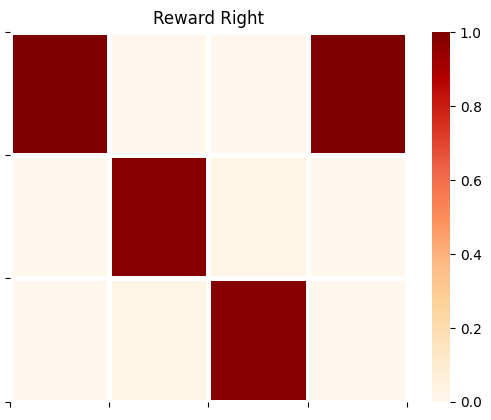

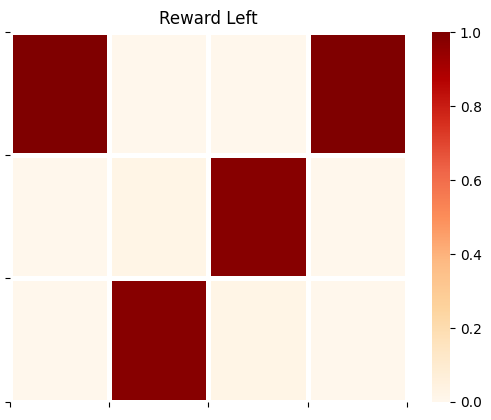

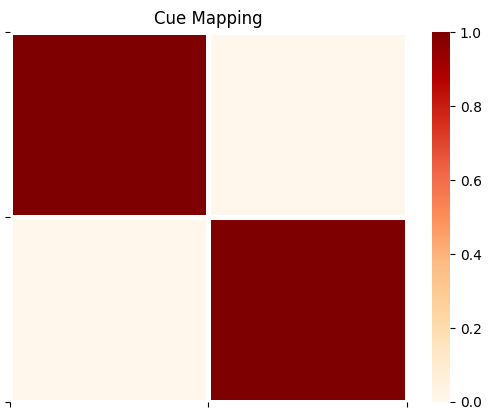

In [4]:
plot_likelihood(A_gp[1][:,:,0],'Reward Right')
plot_likelihood(A_gp[1][:,:,1],'Reward Left')
plot_likelihood(A_gp[2][:,3,:],'Cue Mapping')

In [5]:
#状態遷移確率
# here, we can get the transition mapping directly from the environmental class. So this is the transition mapping that truly describes the environment's dynamics

B_gp = env.get_transition_dist()

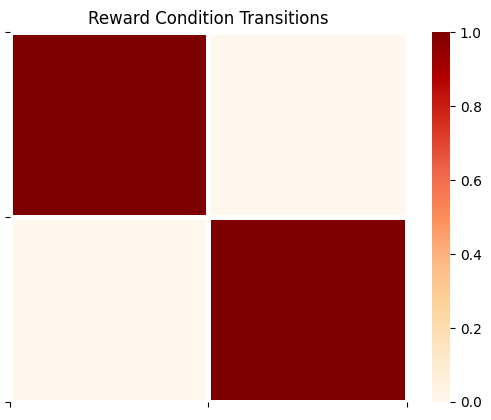

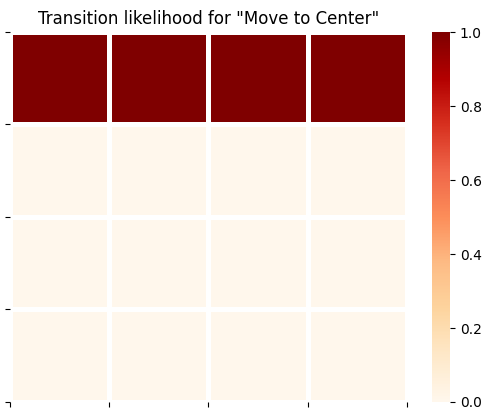

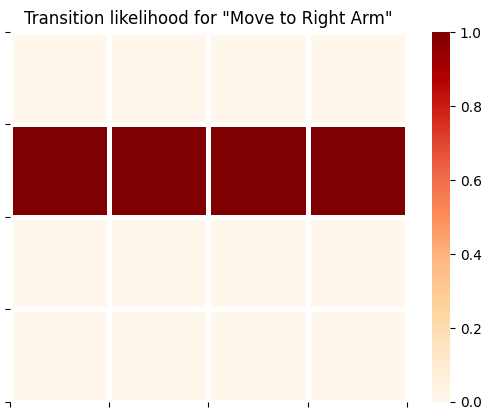

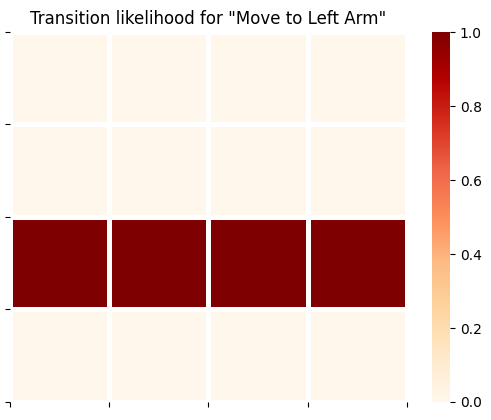

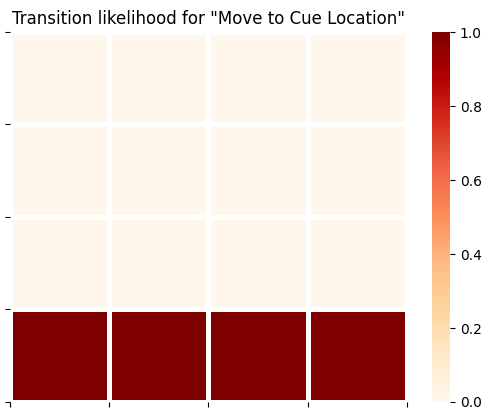

In [6]:
plot_likelihood(B_gp[1][:,:,0],'Reward Condition Transitions')
plot_likelihood(B_gp[0][:,:,0],'Transition likelihood for "Move to Center"')
plot_likelihood(B_gp[0][:,:,1],'Transition likelihood for "Move to Right Arm"')
plot_likelihood(B_gp[0][:,:,2],'Transition likelihood for "Move to Left Arm"')
plot_likelihood(B_gp[0][:,:,3],'Transition likelihood for "Move to Cue Location"')

In [7]:
#生成プロセスのA,Bを生成モデル用にコピー
A_gm = copy.deepcopy(A_gp) # make a copy of the true observation likelihood to initialize the observation model
B_gm = copy.deepcopy(B_gp) # make a copy of the true transition likelihood to initialize the transition model

In [8]:
num_obs = [4, 3, 2] # observation modality dimensions，観測の次元数．
C_shapes = [[o_dim] for o_dim in num_obs]
C_vector = utils.obj_array_zeros(C_shapes)

C_vector[1][1] = 0.3#3.0
C_vector[1][2] = -0.3#3.0

C_vector[0]=np.log(softmax(C_vector[0]))#softmaxで確率分布化⇒pymdpの仕様でlnp(o|C)の形式でAgentに入力する．
C_vector[1]=np.log(softmax(C_vector[1]))
C_vector[2]=np.log(softmax(C_vector[2]))

' C_vector[0]=np.log(softmax(C_vector[0]))#softmaxで確率分布化⇒pymdpの仕様でlnp(o|C)の形式でAgentに入力する．\nC_vector[1]=np.log(softmax(C_vector[1]))\nC_vector[2]=np.log(softmax(C_vector[2])) '

In [9]:
num_states = [4, 2] # hidden state factor dimensions，隠れ状態の次元数．
num_factors = len(num_states)
D = utils.obj_array(num_factors)#初期事前分布の設定
D[0] = utils.onehot(0, num_states[0])
print(D[0])
D[1]=np.array([1/2,1/2])

print(D[1])

[1. 0. 0. 0.]
[0.5 0.5]


In [10]:
#def run_active_inference_loop(my_agent, my_env, T = 10):
batch_size = 1 # number of agents

#jax

A_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(A_gm))#jax用にbatch次元を追加．
B_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(B_gm))
C_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(C_vector))
D_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(D))

batch_keys = jr.split(jr.PRNGKey(0), batch_size)
#batch_keys = jr.split(batch_keys[0], batch_size)
#batch_keys = jr.split(batch_keys[0], batch_size)  

A_dependencies=None#[[0, 4], [1, 4], [2,  4], [3, 4]]
B_dependencies=None
#AIFエージェントの宣言
agents = AIFAgent(A=A_jax, B=B_jax, C=C_jax, D=D_jax, E=None, pA=None, pB=None,  inference_algo="mmp", learn_A=False, learn_B=False, learn_C=False, learn_D=False, learn_E=False, A_dependencies=A_dependencies, B_dependencies=B_dependencies, gamma=1., alpha=1., action_selection="stochastic", policy_len=1, use_utility=True, use_states_info_gain=True, use_param_info_gain=False, use_inductive=False, onehot_obs=False, sampling_mode="full",num_iter=8)
#AIFの処理を行う関数．「@partial～」をコメントアウトするとupdate_agent内でもprint文で出力を確認可能．
@partial(jit, static_argnames=['batch_size','num_history'])
def update_agent(agents, outcomes, actions, infer_args, batch_keys, batch_size=1, num_history=1000):

    #認識・vfeの計算
    #print(outcomes)
    #print(infer_args[0])
    beliefs,err, vfe,kld2, bs, un = agents.infer_states_vfe(outcomes, infer_args[0], past_actions=actions, qs_hist=infer_args[1])
    #kld = agents.calc_KLD_past_currentqs(empirical_prior, infer_args[1], beliefs)
    #行動選択確率（q_pi）の計算，efeの計算
    q_pi, neg_efe, pbs, pkld, pfe, oRisk, pbs_pA, pbs_pB = agents.infer_policies_efe(beliefs)##
    Hqo=pfe-pkld#q(o|π)のEntropy
    negefe_tmp=neg_efe[0]-pbs_pA[0]-pbs_pB[0]#novelty項を除いたEFE
    #print(f'    efe at time {t}: {neg_efe[0]}')

    #行動のサンプリング
    #batch_keys = jr.split(jr.PRNGKey(0), batch_size)
    #actions_t, policy_idx = agents.sample_action_policy_idx(q_pi, rng_key=batch_keys)#q_pi_0
    batch_keys = jr.split(batch_keys[0], batch_size)#乱数のシャッフル
    actions_t = agents.sample_action(q_pi, rng_key=batch_keys)
    #print(policy_idx)
    #past_beliefs=next_past_beliefs

    #行動・観測履歴・信念（認識）の配列の更新
    if actions is not None:
        actions = jnp.concatenate([actions, jnp.expand_dims(actions_t, -2)], -2)##次の推論でsampleactionしたものが使われる？
    else:
        actions = jnp.expand_dims(actions_t, -2)
    outcomes = jtu.tree_map( lambda x: x[:, -num_history:], outcomes)
    #print(f'    outcomes at time {T}: {outcomes}')
    beliefs = jtu.tree_map( lambda x: x[:, -num_history:], beliefs)
    #print(f'    beliefs at time {T}: {beliefs}')
    actions = jtu.tree_map( lambda x: x[:,-num_history:], actions)
    #print(f'    actions at time {T}: {actions}')
    ###

    # Dの学習
    #agents = tree_at(lambda x: x.D, agents, jtu.tree_map(lambda x: x[:, 0], beliefs)) 

    #次のタイムステップのための事前分布（=MMPでは上の処理で作成したbeliefs）の作成
    infer_args = agents.update_empirical_prior(actions_t, beliefs)
    #empirical_prior = beliefs
    #print(f'    infer_args at time {T}: {infer_args}')


    # Learning #
    ##学習用の観測・認識セットの準備
    beliefs_last = jtu.tree_map( lambda x: x[:, -1:], beliefs) # take the last belief
    #print(f'    beliefs_last at time {T}: {beliefs_last}')
    outcomes_last = jtu.tree_map( lambda x: x[:, -1:], outcomes) # take the last outcome
    #print(f'    outcomes_last at time {T}: {outcomes_last}')
    applied_actions_last = jtu.tree_map( lambda x: x[:,-2:-1], actions) # take the last applied action
    #print(f'    applied_actions_last at time {T}: {applied_actions_last}')
    beliefs_last_pair = jtu.tree_map( lambda x: x[:, -2:], beliefs) # take the last two beliefs
    ####

    ##A,Bの更新（学習）
    ##agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair)

    # How to put learning rate
    # lr_pA = 1.0 + jnp.zeros(batch_size)
    # lr_pB = 1.0 + jnp.zeros(batch_size)
    # agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair, lr_pA=lr_pA, lr_pB=lr_pB)
    # learning using moving window (you have to put window size as num_history.)
    # lr_pA = 1.0/num_history + jnp.zeros(batch_size)
    # lr_pB = 1.0/num_history + jnp.zeros(batch_size)
    # applied_actions = jtu.tree_map( lambda x: x[:,:-1], actions)
    # agents = agents.infer_parameters(beliefs, outcomes, applied_actions, beliefs_B=beliefs, lr_pA=lr_pA, lr_pB=lr_pB) 
    #agents = tree_at(lambda x: x.onehot_obs, agents, True)
    #agents = tree_at(lambda x: x.onehot_obs, agents, False)

    vfe =vfe[0][0]
    vfe=[vfe[-1]]#現在時点の隠れ状態に対するVFEを出力
    bs =bs[0][0]
    bs=[bs[-1]]#現在時点の隠れ状態に対するVFEを出力
    un =un[0][0]
    un=[un[-1]]#現在時点の隠れ状態に対するVFEを出力
    #kld=kld[0]#kld1のとき
    ##kld=kld2[0][0]
    #kld=[kld[-1]]
    return agents, outcomes, actions, infer_args, batch_keys, neg_efe, vfe,  bs, un, pbs, pbs_pA, pbs_pB,  Hqo, pkld, pfe, oRisk


In [18]:
T = 5 # number of timesteps
batch_keys = jr.split(batch_keys[0], batch_size)#乱数のシャッフル
obs = env.reset() # reset the environment and get an initial observation
#print(obs)
obs_jax = jtu.tree_map(lambda x: jnp.expand_dims(x, -1).astype(jnp.int32), obs)#jax用にbatch次元？を追加

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Right", "Left"]
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION']
reward_observations = ['No reward','Reward!','Loss!']
cue_observations = ['Cue Right','Cue Left']#CUE LOCATIONにいない限り，ランダムに生成される（CUE LOCATIONに行かなければ，報酬がどちらにあるか分からない）
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))

EFE=[]
VFE=[]
PBS=[]
PKLD=[]
PFE=[]
Risk=[]
Ambiguity=[]
Pragmaticvalue=[]
KLD=[]
BS=[]

#D_env=D
#my_env=FourArmedBandit(D_env)
#obs, first_action = my_env.reset()#初期時刻の観測と行動のサンプリング
#print(obs)
obs_record=[obs]
#chosen_policies=[first_action]
#print(first_action)
#policies=np.array([np.array([[0,0,0,0,0]]), np.array([[0,0,0,0,1]]), np.array([[0,0,0,0,2]]), np.array([[0,0,0,0,3]])])#np.array([np.array([[0]]),t=2:np.array([np.array([[1]]),..)
#print(policies)
beliefs=None
#print(agents.A_dependencies)
#print(agents.B_dependencies)
#print(agents.policies)
for t in range(T):
  if t == 0:
      
      actions_t = None ##first_action#None # no action available at the first time step
      #print(actions_t)
      actions = None # no action available at the first time step
      #prob_pi = None
      #prob_pi = jnp.expand_dims(jnp.array([[0,0,0,0,self.s_action]]), -2) D_jax[4]
      infer_args = (agents.D, None,)#(qs_pi, qs_hist)
      outcome_t  = None
      outcomes = None
      #empirical_prior =agents.D　#KLD計算用の事前分布．
  #else:
      #print("selected action",actions_t)
      #empirical_prior = agents.compute_expected_state(actions_t, empirical_prior)#KLD計算用の事前分布．事前分布をB*qsとする場合

  batch_keys = jr.split(batch_keys[0], batch_size)
  outcome_t  = jtu.tree_map(lambda x: jnp.expand_dims(x, -1), obs_jax)
  #print(f'    outcome_t at time {T}: {outcome_t}')
  
  if outcomes is None:
      outcomes = outcome_t
  else:
      outcomes = jtu.tree_map(lambda prev_o, new_o: jnp.concatenate([prev_o, new_o], -1), outcomes, outcome_t) 

  num_history=5 #推論する時間幅．5であれば現在から過去5タイムステップ分の隠れ状態を推論．
  agents, outcomes, actions, infer_args, batch_keys, neg_efe, vfe,  bs, un, pbs,  pbs_pA, pbs_pB,  Hqo, pkld, pfe, oRisk = update_agent(
      agents, 
      outcomes, 
      actions, 
      infer_args, 
      batch_keys,
      batch_size=batch_size,
      num_history=num_history
  )
 
  """ if T < num_history:
    qs_1 = infer_args[1][0][0, 0] # snapshot of s1 for D-learning """
  actions_t = actions[:,-1]
  #print(actions_t)
  #print(actions_t[0][4])
  obs = env.step(actions_t[0])#次の時刻の観測をサンプリング
  msg = """[Step {}] Action: [Move to {}]"""
  print(msg.format(t, location_observations[int(actions_t[0][0])]))
  #prev_obs=[obs]#次の時刻の観測を指定．
  obs_record.append(obs)
  obs_jax = jtu.tree_map(lambda x: jnp.expand_dims(x, -1).astype(jnp.int32), obs)#jax用にbatch次元？を追加
  msg = """[Step {}] Observation: [{},  {}, {}]"""
  print(msg.format(t, location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))
  #chosen_policy_idx=int(actions_t[4])    

  #情報量記録
  """ efe = np.array(-neg_efe[0])
  min_index = np.argmin(efe)  # efeの最小値のインデックスを取得
  efe_min = efe[min_index] """
  #print(f'    efe_min at time {T}: {efe_min}')
  #efes.append(efe_min)
  PBS.append(pbs)#=np.append(PBS,pbs)  
  PKLD.append(pkld)
  PFE.append(pfe)
  Risk.append(oRisk)  
  ambi=pfe-pbs-pkld
  Ambiguity.append(ambi)
  Pv=-oRisk-Hqo
  Pragmaticvalue.append(Pv)
  #chosen_policies.append(chosen_policy_idx)
  #VFE.append(vfe)
  EFE.append(-1*neg_efe)


#可視化のためのデータ整形
PBS=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PBS) 
PBS=np.array(PBS) 
PBS=PBS.T
PBS=PBS.tolist()
PKLD=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PKLD) 
PKLD=np.array(PKLD) 
PKLD=PKLD.T
PKLD=PKLD.tolist()
PFE=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PFE) 
PFE=np.array(PFE) 
PFE=PFE.T
PFE=PFE.tolist()
Ambiguity=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Ambiguity) 
Ambiguity=np.array(Ambiguity) 
Ambiguity=Ambiguity.T
Ambiguity=Ambiguity.tolist()
Risk=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Risk) 
Risk=np.array(Risk) 
Risk=Risk.T
Risk=Risk.tolist()
Pragmaticvalue=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Pragmaticvalue) 
Pragmaticvalue=np.array(Pragmaticvalue) 
Pragmaticvalue=Pragmaticvalue.T
Pragmaticvalue=Pragmaticvalue.tolist()

EFE=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), EFE) 
EFE=np.array(EFE)
EFE=EFE.T
EFE=EFE.tolist()

 === Starting experiment === 
 Reward condition: Right, Observation: [CENTER, No reward, Cue Right]
[Step 0] Action: [Move to RIGHT ARM]
[Step 0] Observation: [RIGHT ARM,  Reward!, Cue Left]
[Step 1] Action: [Move to CENTER]
[Step 1] Observation: [CENTER,  No reward, Cue Left]
[Step 2] Action: [Move to RIGHT ARM]
[Step 2] Observation: [RIGHT ARM,  Reward!, Cue Right]
[Step 3] Action: [Move to LEFT ARM]
[Step 3] Observation: [LEFT ARM,  Loss!, Cue Right]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM,  Loss!, Cue Left]
